In [10]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model


In [16]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = False
use_jet_mass = True
tau_x_1 = False
N = 8
model_type = 'best'
extra_name = ''
use_fourth_layer = True

if tau_x_1:
    extra_name = '_tau_x_1'
if not use_fourth_layer:
    extra_name = '_no_fourth_layer'

test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=21, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [17]:
#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
feat_names = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            feat_names.append('tau_'+str(i+1)+'_'+str(0.5))
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
        else:
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
else:
    for i in range(N-1):
        feat_names.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(feat_names, ['background_prob', 'signal_prob']))
feats = df_test.drop(columns=['background_prob', 'signal_prob'])
means = np.array(df_test.mean(0))

In [18]:
def NeuronFiringEvaluator(model, x, use_fourth_layer = True):
    data = torch.tensor(x, dtype = torch.float32).cuda()
    FiringEvaluator = []
    layer_tags = []
    with torch.no_grad():
        model.eval()
        data = model.dense1(data)
        data = model.relu(data)
        data = model.dropout2(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 1')
    
        data = model.dense2(data)
        data = model.relu(data)
        data = model.dropout2(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 2')

        data = model.dense3(data)
        data = model.relu(data)
        data = model.dropout1(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 3')
        
        if use_fourth_layer:
            data = model.dense4(data)
            data = model.relu(data)
            data = model.dropout1(data)
            FiringEvaluator.append(data.cpu().numpy().sum(0))
            layer_tags.append('Layer 4')

        data = model.dense5(data)
        presoftmax = data.cpu().numpy()
        data = model.softmax(data)
        result = data.cpu().numpy()
    return FiringEvaluator, layer_tags
        
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline', save=False):
    tag = 'baseline' if tag == ''else tag.strip('_')
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    print(N_cols, N_rows)
    Nnodes = 0
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
        Nnodes += len(FiringMatrix_0[ii])
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
    s0 = np.sum(FiringMatrix_0 < 0.2)/Nnodes
    s1 = np.sum(FiringMatrix_1 < 0.2)/Nnodes
    sall = np.sum(np.maximum(FiringMatrix_0, FiringMatrix_1) < 0.2)/Nnodes
    print("Sparsity measure (RNA < 0.2) for background jets: ", s0)
    print("Sparsity measure (RNA < 0.2) for signal jets: ", s1)
    print("Overall sparsity measure (RNA < 0.2): ", sall)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('grey')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_xlabel('Network Activation Layers', fontsize = 40)
    axes.set_ylabel('Node in hidden layer', fontsize = 40)
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical',  fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/NAP_MB8S_{}.png".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_facecolor('grey')
    axes.set_xlabel('Network Activation Layers', fontsize=40)
    axes.set_ylabel('Node in hidden layer', fontsize=40)
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical', fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dNAP_MB8S_{}.png".format(tag))
    plt.show()
    return (s0, s1, sall)


4 200
Sparsity measure (RNA < 0.2) for background jets:  0.734
Sparsity measure (RNA < 0.2) for signal jets:  0.702
Overall sparsity measure (RNA < 0.2):  0.452


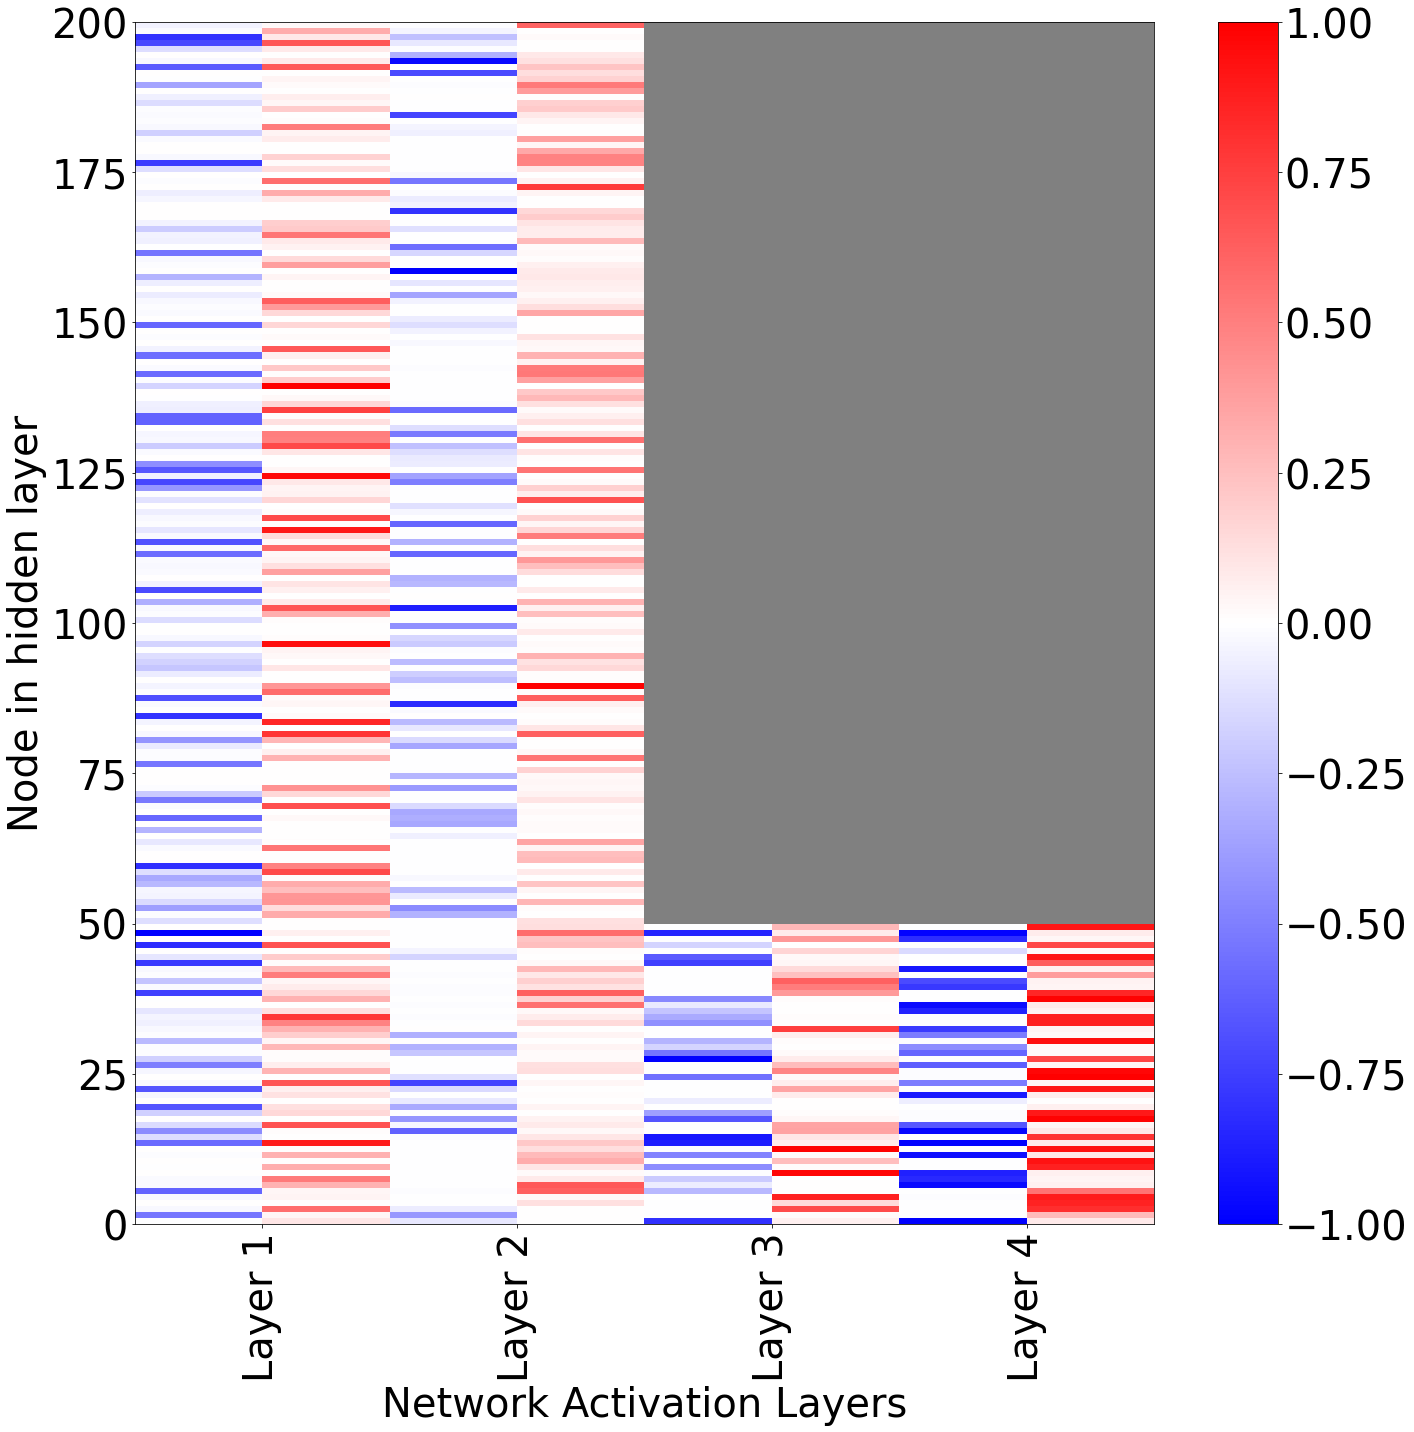

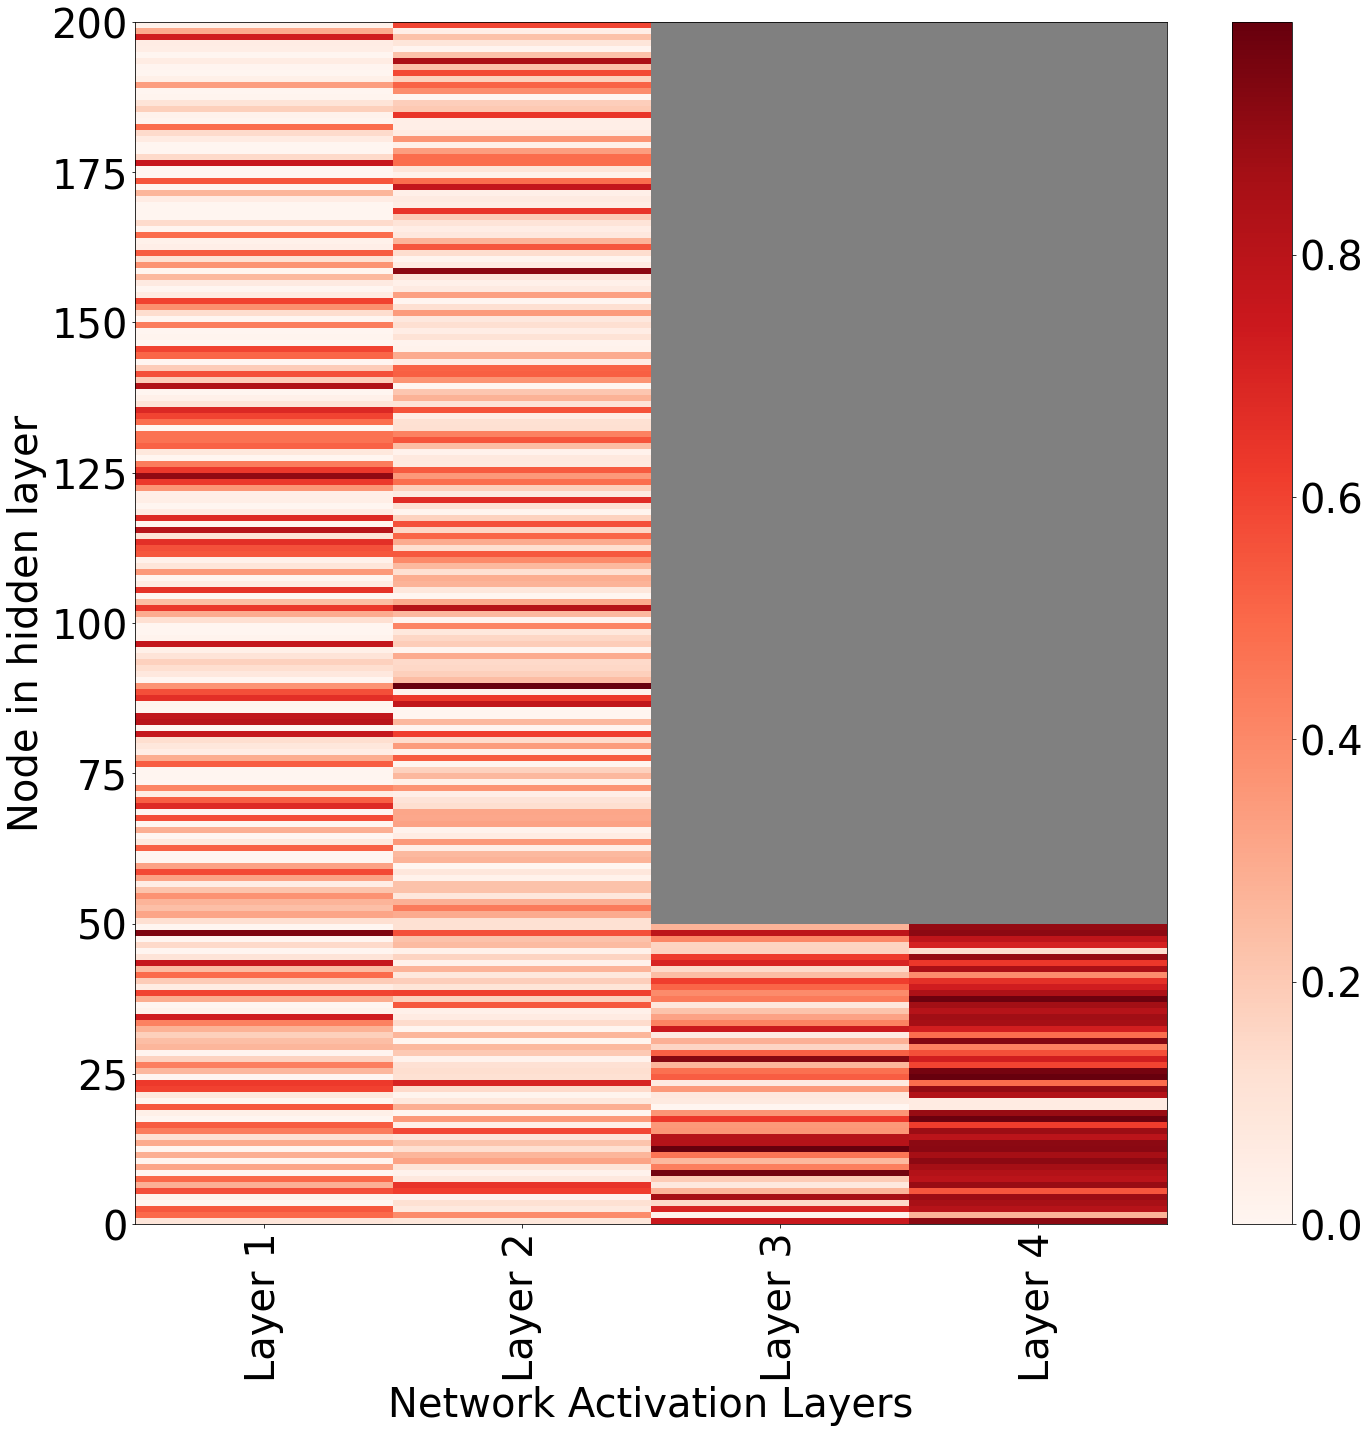

In [19]:
data = np.copy(feats)
FiringMatrix_0, layer_tags = NeuronFiringEvaluator(model, data[labels[:,0]==1, :], use_fourth_layer)
FiringMatrix_1, layer_tags = NeuronFiringEvaluator(model, data[labels[:,1]==1, :], use_fourth_layer)
extra_name = extra_name.strip('_') if extra_name else 'baseline'
s = ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag=extra_name, save=True)